In [57]:
import pandas as pd
import numpy as np
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [58]:
fd = open('/home/hasan/Desktop/FYP-II/data/AnnotatedData2.csv',encoding="utf-8", errors='replace')
data_frame = pd.read_csv(fd)
#print(data_frame)

def remove_columns(data_frame,keyword):
    #create series of true and false. True is assigned for yes/no. False for undefined
    removed_columns = data_frame['class'] != (keyword)
    #output dataframe without undeined
    data_frame_edited = data_frame[removed_columns]
    return data_frame_edited

def replace_keyword(data_frame,keyword_to_replace,new_keyword):
    replaced_keyword_data_frame = data_frame.replace("keyword_to_replace","new_keyword")
    return replaced_keyword_data_frame

df_1 = remove_columns(data_frame,"undefined")
df_2 = remove_columns(df_1,"Undefined")
df_3 = replace_keyword(df_2,"No PI","no")
df_4 = replace_keyword(df_3,"PI","yes")
df_5 = replace_keyword(df_4,"Yes","yes")
df_6 = replace_keyword(df_5,"No", "no")

final_data_frame = df_6

print(final_data_frame)

     class                                               text
0       no  i'll  buy  the  iphone   x  if it can  get  ac...
1       no  Some dude in FB selling the  iPhone   X  64 gb...
2      yes  Home dab emote man today and I  get  hopped on...
3      yes                               Buy  an  iPhone   X 
4       no  I hate iOS 11. My  iPhone  6+ works 10X slower...
7       no  Bo-go sale tomorrow at T-Mobile  buy  one  get...
8      yes  I can  get  the  iPhone   X  here.... If I'm w...
9      yes  When you  buy  an  Iphone   X  with Unlimited ...
10     yes  @ Mrwhosetheboss  i really  wish  i  get  to m...
11      no  @ sprint  @sprintcare  if I switch to @TMobile...
12      no  Oneplus 5t has faster face recognition than  i...
13      no  Don't  buy  an  iPhone   X  if you're ugly. I ...
14      no  Could  buy  2x 5T with the price I paid for th...
15     yes  My friend shopping:  iPhone   X  is not that e...
16     yes  What if there was upgrade to an  iPhone  8 or ...
19      

In [59]:
#creating the training and testing datasets
class_label = final_data_frame['class']
text = final_data_frame['text']

X_train, X_test, y_train, y_test = train_test_split(text, class_label, test_size=0.2, random_state=42)

In [60]:
#Cleaning the data
stemmer = PorterStemmer()
from nltk.corpus import stopwords

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    #tokens = [word for word in tokens if word not in stopwords.words('english')]
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

#--- Training set

corpus = []
for text in X_train:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)
        
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)        
        
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#--- Test set

test_set = []
for text in X_test:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

from pandas import *
df = DataFrame({'Before': X_train, 'After': corpus})
print(df.head(20))

prediction = dict()

                                                 Before  \
678   Now that is some  awesome  explanation @RajivM...   
564   Apple  iPhone   X  Review: The Best Yet!  http...   
8     I can  get  the  iPhone   X  here.... If I'm w...   
164   Of all the flagship phones I chose the S8 (alt...   
185   I couldn't  get  an  iPhone   X  today bc they...   
1016             How  bad  do i want this  iPhone   X     
689   @ Apple  - I wasn't going to  buy  an  iPhone ...   
831         My dilemma is i couldnt decide if i should:   
958   @ nerdwomanisme   iPhone   X  review: this thi...   
965   What do you think of the  iphone   x  (i  hate...   
764   When you  purchase  the  iPhone   X  but it do...   
702   i  think ima  buy  the  iphone   x    i  knoww...   
509   It is real, important, and if you actually wan...   
489   But instead of giving out just one for example...   
944           I   wish  the  iPhone   x  came in a plus   
281   You don't  need  those perfect tooth. You just... 

In [61]:
#Applying Multinomial Naïve Bayes learning method
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

#Applying Bernoulli Naïve Bayes learning method
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

#Applying Logistic regression learning method
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

/home/hasan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hasan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


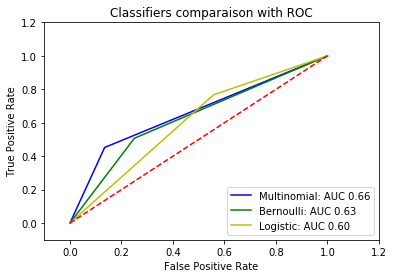

In [62]:
#ROC curve
def formatt(x):
    if x == 'no':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [63]:
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["yes", "no"]))

ValueError: Number of classes, 5, does not match size of target_names, 2. Try specifying the labels parameter

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(class_label)))
    plt.xticks(tick_marks, set(class_label), rotation=45)
    plt.yticks(tick_marks, set(class_label))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()